<a href="https://colab.research.google.com/github/ViniitMe/Machine-Learning-foundation-and-Applications/blob/master/Video_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

import cv2
import glob
import imutils
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import skimage.color as color
import skimage.segmentation as seg
import matplotlib.pyplot as plt
from google.colab import drive

In [0]:
# Mounting google drive
drive.mount("/content/drive")

Mounted at /content/drive


# Reading Image File

In [0]:
# Loading image file
img_file = []
for img in glob.glob("/content/drive/My Drive/15MI33017/video/*.jpg"):
  image = cv2.imread(img)
#   image = image.flatten()
  img_file.append(image)

In [0]:
data = img_file.copy()

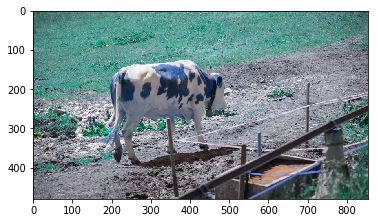

In [0]:
plt.imshow(data[7])

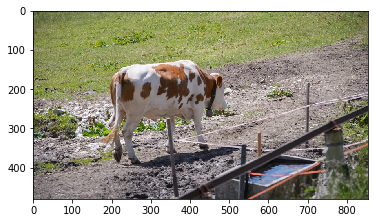

In [0]:
from google.colab.patches import cv2_imshow
img = cv2.cvtColor(data[7],cv2.COLOR_BGR2RGB)
# cv2_imshow(img)
# cv2.waitKey(0)
plt.imshow(img)

# Spatial Segmentation

SLIC(Simple linear iterative clustering) algorithm actually uses K-Means under the hood. It takes in all the pixel values of the image and tries to separate them out into the given number of sub-regions.

In [0]:
# SLIC Implementation
image_slic = seg.slic(data[7],n_segments=200)

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5793ff69b0>)

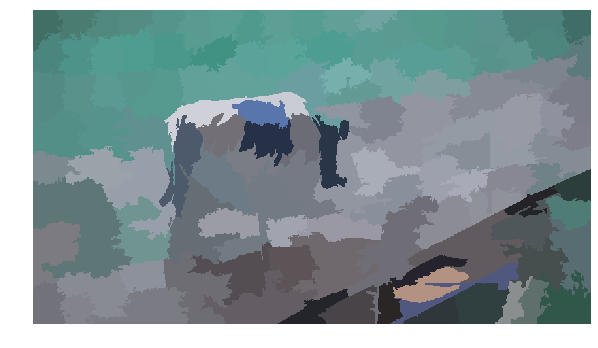

In [0]:
def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax
image_show(color.label2rgb(image_slic, data[7], kind='avg'))


Felzenszwalb Implementation

In [0]:
image_felzenszwalb = seg.felzenszwalb(data[7]) 
np.unique(image_felzenszwalb).size

5603

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f57988d8898>)

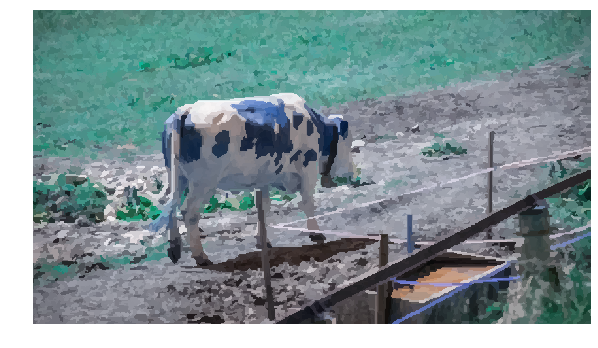

In [0]:
image_felzenszwalb_colored = color.label2rgb(image_felzenszwalb, data[7], kind='avg')
image_show(image_felzenszwalb_colored)

Chan vese Implementation

Text(0.5, 1.0, 'Final Level Set')

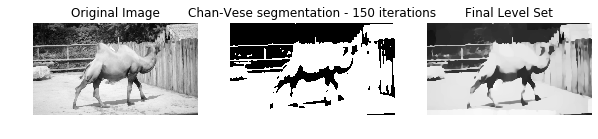

In [0]:
# image = data[7]
cv = seg.chan_vese(image, mu=0.25, lambda1=1, lambda2=1, tol=1e-3, max_iter=200,
               dt=0.5,init_level_set="checkerboard", extended_output=True)

fig, axes = plt.subplots(1, 3, figsize=(10, 10))
ax = axes.flatten()

ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Original Image", fontsize=12)

ax[1].imshow(cv[0], cmap="gray")
ax[1].set_axis_off()
title = "Chan-Vese segmentation - {} iterations".format(len(cv[2]))
ax[1].set_title(title, fontsize=12)

ax[2].imshow(cv[1], cmap="gray")
ax[2].set_axis_off()
ax[2].set_title("Final Level Set", fontsize=12)


# plt.imshow()

# Parameter selection for KMeans

In [0]:
# KMeans with OpenCV
image = data[7]
img=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
vectorized = img.reshape((-1,3))
vectorized = np.float32(vectorized)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
attempts=10
ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
ret2,label2,center2=cv2.kmeans(vectorized,6,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)

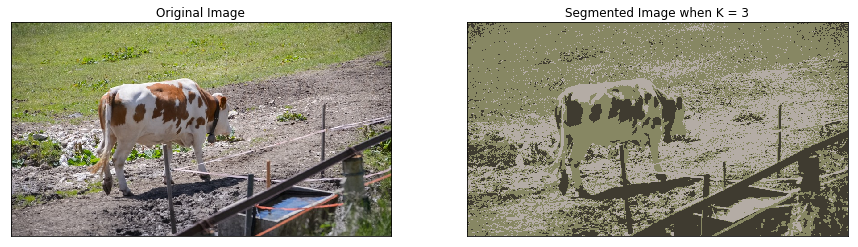

In [0]:
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((img.shape))
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(result_image)
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

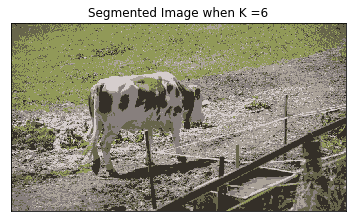

In [0]:
center2 = np.uint8(center2)
res2 = center2[label2.flatten()]
result_image = res2.reshape((img.shape))
plt.title('Segmented Image when K =' +str(6)), plt.xticks([]), plt.yticks([])
plt.imshow(result_image)

# Spatial Segmentation using KMeans

In [0]:
def kmeans(image):
        vectorized=image.reshape(-1,3)
        vectorized=np.float32(vectorized)
        criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,10, 1.0)
        ret,label,center=cv2.kmeans(vectorized,3,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
        res = center[label.flatten()]
        segmented_image = res.reshape((image.shape))
        return label.reshape((image.shape[0],image.shape[1])),segmented_image.astype(np.uint8)

In [0]:
# Selected K value=3
segmented_img = []
for i in range(len(data)):
  label,result = kmeans(data[i])
  segmented_img.append(result)

Segmented images are stored in segmented_img file.
# Showing few segmented results

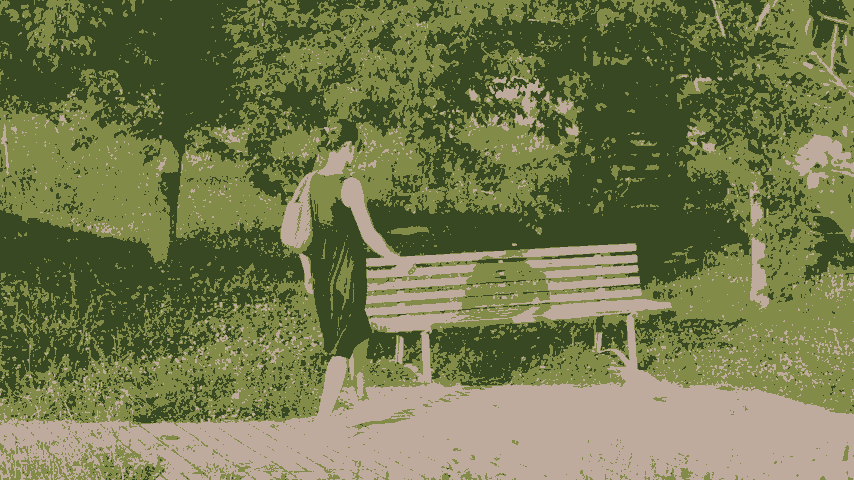

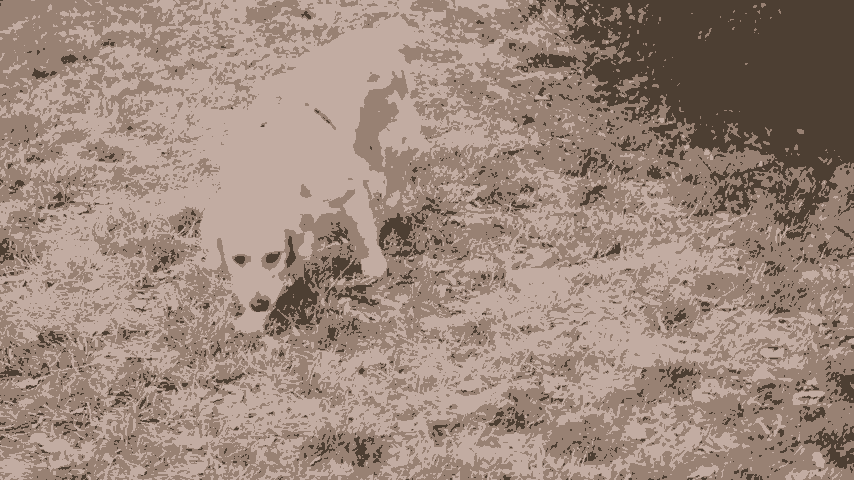

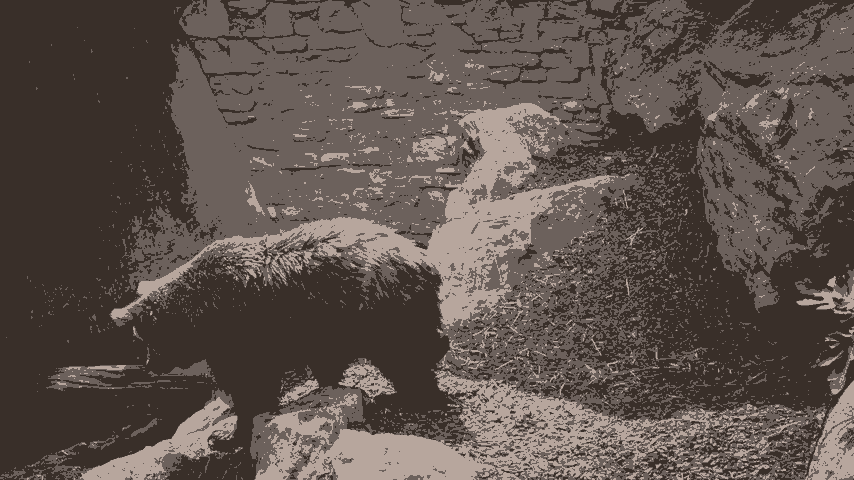

In [0]:
cv2_imshow(segmented_img[10])
cv2_imshow(segmented_img[50])
cv2_imshow(segmented_img[47])

# Temporal Segmentation using original images (via KMeans)
Input: Colored Images

In [0]:
df = []
for img in glob.glob("/content/drive/My Drive/15MI33017/video/*.jpg"):
  image = cv2.imread(img)
  image = image.flatten()
  df.append(image)

In [0]:
x = np.reshape(df, (79,df[0].shape[0]))

In [0]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(x)
kmeans.cluster_centers_.shape

(10, 1229760)

Note: Different animals are visible in the centroid images. This has been trained on RGB images.

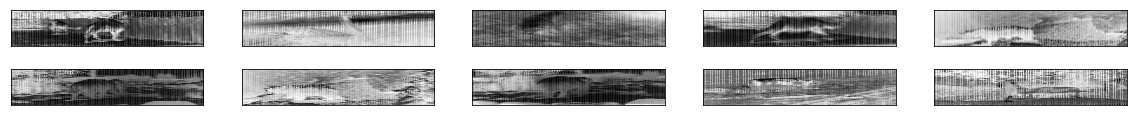

In [0]:
fig, ax = plt.subplots(2, 5, figsize=(20, 2))
centers = kmeans.cluster_centers_.reshape(10, 480, 854*3)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

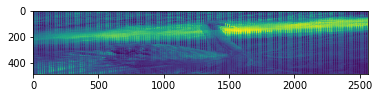

In [0]:
plt.imshow(centers[1])

# Temporal Segmentation using segmented images
Input: Binary Images (output of spatial segmentation)

In [0]:
df = []
for i in range(len(segmented_img)):
  image = segmented_img[i].flatten()
  df.append(image)

Training

In [0]:
x = np.reshape(df, (79,df[0].shape[0]))
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(x)
kmeans.cluster_centers_.shape

(10, 1229760)

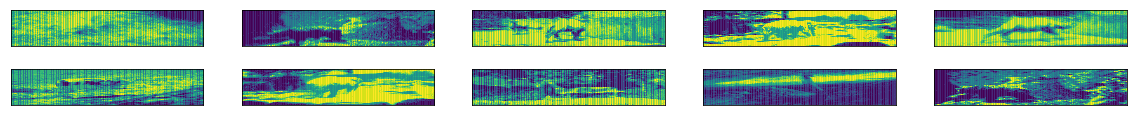

In [0]:
fig, ax = plt.subplots(2, 5, figsize=(20, 2))
centers = kmeans.cluster_centers_.reshape(10, 480, 854*3)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest')